In [2]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError

from sklearn.metrics import r2_score, mean_squared_error



2023-08-10 08:27:24.101798: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 08:27:24.190489: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 08:27:24.203694: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 08:27:25.492072: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# x_train = features, y_train = target

df = pd.read_csv('new-pci-thesis-cleaned.csv')


x = df.drop('PCI',axis=1)
y = df.PCI


# Seed value
# Apparently you may use different seed values at each stage
seed_value= 33

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# import keras.backend.tensorflow_backend as K
# session_conf =  tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, random_state=seed_value)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.1111, random_state=seed_value)

2023-08-10 08:27:27.410202: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
def scale_datasets(x_train, x_test):

  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled
  return x_train, x_test
x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)

x_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AC1     285 non-null    float64
 1   AC2     285 non-null    float64
 2   AC3     285 non-null    float64
 3   BE1     285 non-null    float64
 4   BE2     285 non-null    float64
 5   BE3     285 non-null    float64
 6   D1      285 non-null    float64
 7   D2      285 non-null    float64
 8   D3      285 non-null    float64
 9   F1      285 non-null    float64
 10  F2      285 non-null    float64
 11  F3      285 non-null    float64
 12  G1      285 non-null    float64
 13  G2      285 non-null    float64
 14  G3      285 non-null    float64
 15  H1      285 non-null    float64
 16  H2      285 non-null    float64
 17  H3      285 non-null    float64
dtypes: float64(18)
memory usage: 40.2 KB


In [5]:
hidden_units1 = 12
# hidden_units2 = 12
# hidden_units3 = 12
# hidden_units1 = 160
# hidden_units2 = 480
# hidden_units3 = 256
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    # Dropout(0.2),
    # Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    # Dropout(0.2),
    # Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='relu')
  ])
  return model
# build the model
model = build_model_using_sequential()

In [6]:
# import tensorflow as tf
# from tensorflow.keras.metrics import Metric
# from tensorflow.keras import backend as K

# class R2KerasMetric(Metric):
#     def __init__(self, name='r2_keras', **kwargs):
#         super(R2KerasMetric, self).__init__(name=name, **kwargs)
#         self.r2_values = self.add_weight(name='r2_values', initializer='zeros')
#         self.total_samples = self.add_weight(name='total_samples', initializer='zeros')

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true_flat = tf.reshape(y_true, shape=(-1,))
#         y_pred_flat = tf.reshape(y_pred, shape=(-1,))
#         residual = y_true_flat - y_pred_flat
#         ss_res = K.sum(K.square(residual))
#         ss_tot = K.sum(K.square(y_true_flat - K.mean(y_true_flat)))
#         r2 = 1 - ss_res / (ss_tot + K.epsilon())
#         current_samples = tf.cast(tf.size(y_true), dtype=tf.float32)
#         self.r2_values.assign_add(r2 * current_samples)
#         self.total_samples.assign_add(current_samples)

#     def result(self):
#         return self.r2_values / self.total_samples

#     def reset_states(self):
#         self.r2_values.assign(0.0)
#         self.total_samples.assign(0.0)

#     # Add the variables property as required by Keras
#     @property
#     def variables(self):
#         return self._collected_trainable_weights

#     # Override the get_config method to avoid issues with serialization
#     def get_config(self):
#         return {}

In [7]:
# def r2_keras(y_true, y_pred):
#     r2 = r2_score(y_true, y_pred)
#     return tf.convert_to_tensor(r2, dtype=tf.float32)  # Convert the result to a tensor


# loss function
msle = MeanSquaredLogarithmicError()
mse = MeanSquaredError()
model.compile(
    loss=mse, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=['mse' ]
)


In [8]:
# train the model
history = model.fit(
    x_train_scaled.values, 
    y_train.values, 
    epochs=40, 
    batch_size=32,
    validation_split=0.2
    # validation_data=(x_val, y_val)
)

Epoch 1/40


8/8 [==============================] - 1s 28ms/step - loss: 3694.7705 - mse: 3694.7705 - val_loss: 3915.8108 - val_mse: 3915.8108
Epoch 2/40
8/8 [==============================] - 0s 5ms/step - loss: 3650.6304 - mse: 3650.6304 - val_loss: 3849.2883 - val_mse: 3849.2883
Epoch 3/40
8/8 [==============================] - 0s 6ms/step - loss: 3566.5813 - mse: 3566.5813 - val_loss: 3732.0127 - val_mse: 3732.0127
Epoch 4/40
8/8 [==============================] - 0s 6ms/step - loss: 3429.3142 - mse: 3429.3142 - val_loss: 3547.8657 - val_mse: 3547.8657
Epoch 5/40
8/8 [==============================] - 0s 5ms/step - loss: 3223.8542 - mse: 3223.8542 - val_loss: 3299.5947 - val_mse: 3299.5947
Epoch 6/40
8/8 [==============================] - 0s 6ms/step - loss: 2950.8271 - mse: 2950.8271 - val_loss: 2992.5784 - val_mse: 2992.5784
Epoch 7/40
8/8 [==============================] - 0s 6ms/step - loss: 2623.5286 - mse: 2623.5286 - val_loss: 2630.8169 - val_mse: 2630.8169
Epoch 8/40
8/8 [==============

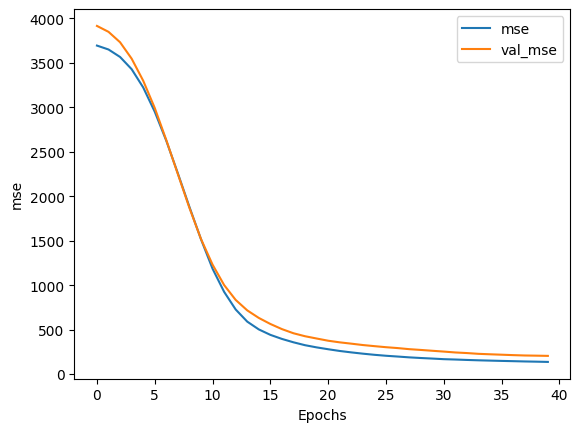

In [9]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mse')


In [10]:
x_test_prediction = model.predict(x_test_scaled)
x_train_prediction = model.predict(x_train_scaled)
model.evaluate(x_test_scaled,y_test)

1/1 [==============================] - 0s 138ms/step - loss: 183.8063 - mse: 183.8063


[183.80628967285156, 183.80628967285156]

In [11]:

test_mse = model.evaluate(x_test_scaled,y_test)[0]

import numpy as np

test_r2 = 1- test_mse / np.var(y)
train_r2 = 1 - (history.history['mse'][-1]) / np.var(y)
validation_r2 = 1 - (history.history['val_mse'][-1] / np.var(y))
print(f"test_r2 = {test_r2}")
print(f"train_r2 = {train_r2}")
print(f"validation_r2 = {validation_r2}")

1/1 [==============================] - 0s 25ms/step - loss: 183.8063 - mse: 183.8063
test_r2 = 0.606630144702222
train_r2 = 0.7078877539895123
validation_r2 = 0.5623892620021058


line: y = 0.8532980242568268 * x + 4.936943767241473


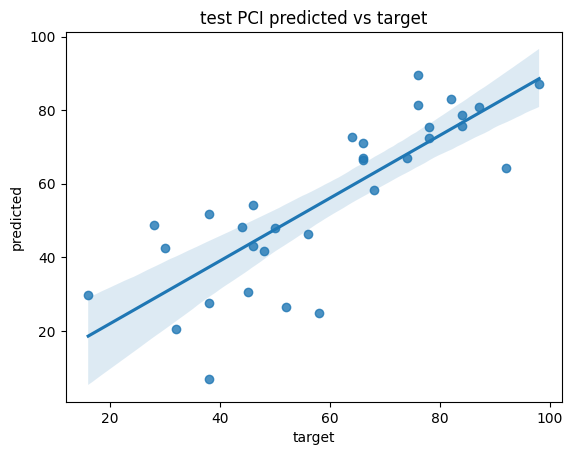

In [12]:
import seaborn as sns
ax = sns.regplot(x=y_test ,y= x_test_prediction,)
ax.set(title = 'test PCI predicted vs target', xlabel='target', ylabel='predicted')
#calculate slope and intercept of regression equation
import scipy
slope, intercept, r, p, sterr = scipy.stats.linregress(x=ax.get_lines()[0].get_xdata(),
                                                       y=ax.get_lines()[0].get_ydata())

print(f"line: y = {slope} * x + {intercept}")


line: y = 0.7811639201484741 * x + 10.993541440525199


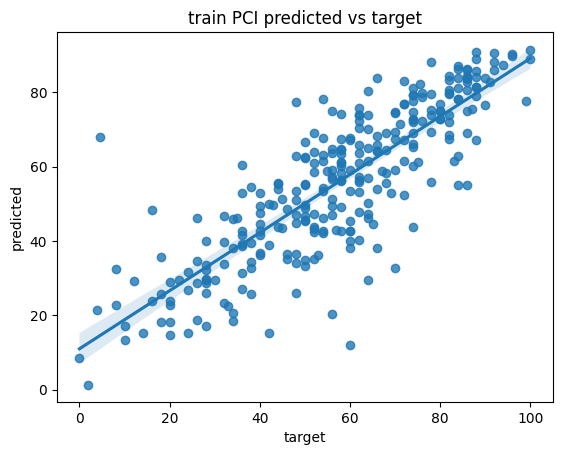

In [13]:
ax = sns.regplot(x=y_train, y= x_train_prediction)
ax.set(title = 'train PCI predicted vs target', xlabel='target', ylabel='predicted')

import scipy
slope, intercept, r, p, sterr = scipy.stats.linregress(x=ax.get_lines()[0].get_xdata(),
                                                       y=ax.get_lines()[0].get_ydata())

print(f"line: y = {slope} * x + {intercept}")



In [14]:
z = pd.DataFrame({'AC1': [0.0],
                  'AC2': [0.0],
                  'AC3': [1.2],
                  'BE1': [0.0],
                  'BE2': [0.78],
                  'BE3': [0.11],
                  'D1': [0.0],
                  'D2': [0.0],
                  'D3': [0.2],
                  'F1': [0.0],
                  'F2': [0.2],
                  'F3': [0.0],
                  'G1': [0.0],
                  'G2': [0.0],
                  'G3': [0.33],
                  'H1': [0.0],
                  'H2': [0.0],
                  'H3': [0.32]})
# model.predict()
z = pd.DataFrame(z)
_, z = scale_datasets(x_train, z)

model.predict(z)


1/1 [==============================] - 0s 23ms/step


array([[20.541225]], dtype=float32)